<a href="https://colab.research.google.com/github/kanri3/deep_learning_day3_day4/blob/main/pytorch_hands_on_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 連載『PyTorch入門』のノートブック（1）

※上から順に実行してください。上のコードで実行したものを再利用しているところがあるため、すべて実行しないとエラーになるコードがあります。  
　すべてのコードを一括実行したい場合は、メニューバーから［ランタイム］－［すべてのセルを実行］をクリックしてください。

※「Python 3」を利用してください。  
　Python 3を利用するには、メニューバーから［ランタイム］－［ランタイムのタイプを変更］を選択すると表示される［ノートブックの設定］ダイアログの、［ランタイムのタイプ］欄で「Python 3」に選択し、その右下にある［保存］ボタンをクリックしてください。

# 第1回　難しくない！　PyTorchでニューラルネットワークの基本

## ■PyTorchとは？

- 人気急上昇中（参考：「[PyTorch vs. TensorFlow、ディープラーニングフレームワークはどっちを使うべきか問題 (1/2)：気になるニュース＆ネット記事 - ＠IT](https://www.atmarkit.co.jp/ait/articles/1910/31/news028.html)）」
- Pythonic（＝Pythonのイディオムをうまく活用した自然なコーディングが可能）
- 柔軟性や拡張性に優れる（特に“define-by-run”：実行しながら定義／eager execution：即時実行なので、例えばモデルのフォワードプロパゲーション（順伝播）時にif条件やforループなどの制御フローを書いて動的に計算グラフを変更したりできる）

特にNLP（Natural Language Processing：自然言語処理）の分野では、研究者はさまざまな長さの文を訓練する必要性があるため、動的な計算グラフが不可欠。実際に「PyTorchがデファクトスタンダードになっている」と筆者が初めて聞いたのは、NLPに関しての話だった。

## ■本稿の目的と方針

PyTorchでニューラルネットワークを定義するための最重要の基礎知識を最短で紹介する。

- PyTorchのチュートリアルは最初からCNNで最初から複雑（※これはある程度のニューラルネットワークの知識がない人を門前払いする意味があると思う）
- まずはニューラルネットワークの原型「ニューロン」を実装することで、核となる機能を理解する
- 「ニューロン」「活性化関数」「正則化」「勾配」「確率的勾配降下法（SGD）」といった概念が分からない場合は、『[TensorFlow 2＋Keras（tf.keras）入門 - ＠IT](https://www.atmarkit.co.jp/ait/subtop/features/di/tf2keras_index.html)』の第1回～第3回で挙動を示しながら分かりやすく説明しているので、先にそちらを一読してほしい
- 最終的には、基本的なニューラルネットワーク＆ディープラーニングのコードが思いどおりに書けるようになる

## ■本稿で説明する大まかな流れ

- （1）ニューロンのモデル定義
- （2）フォワードプロパゲーション（順伝播）
- （3）バックプロパゲーション（逆伝播）と自動微分（Autograd）
- （4）PyTorchの基礎： テンソルとデータ型
- （5）データセットとデーターローダー（DataLoader）
- （6）ディープニューラルネットのモデル定義
- （7）学習／最適化（オプティマイザー）
- （8）評価／精度検証

## ■（1）ニューロンのモデル定義

###  【チェック】Pythonバージョン（※3系を使うこと）
Colabにインストール済みのものを使う。もし2系になっている場合は、メニューバーの［ランタイム］－［ランタイムのタイプを変更］をクリックして切り替えてほしい。

In [13]:
import sys
print('Python', sys.version)
# Python 3.6.9 (default, Nov  7 2019, 10:44:02)  …… などと表示される

Python 3.7.11 (default, Jul  3 2021, 18:01:19) 
[GCC 7.5.0]


###  【チェック】PyTorchバージョン
基本的にはColabにインストール済みのものを使う。

In [14]:
import torch
print('PyTorch', torch.__version__)
# PyTorch 1.3.1 ……などと表示される

PyTorch 1.9.0+cu102


### リスト1-0　［オプション］ライブラリ「PyTorch」最新バージョンのインストール

In [15]:
#!pip install torch        # ライブラリ「PyTorch」をインストール
#!pip install torchvision  # 画像／ビデオ処理のPyTorch用追加パッケージもインストール

# 最新バージョンにアップグレードする場合
!pip install --upgrade torch torchvision

# バージョンを明示してアップグレードする場合
#!pip install --upgrade torch===1.4.0 torchvision===0.5.0

# 最新バージョンをインストールする場合
#!pip install torch torchvision

# バージョンを明示してインストールする場合
#!pip install torch===1.4.0 torchvision===0.5.0

このコードのポイント：
- 「torchvision」パッケージは本稿では使っていないが、同時にインストールしないとパッケージ関係が不整合となるため、インストールしておく必要がある
- 実行後にランタイムを再起動する必要がある

### ［オプション］【チェック】PyTorchバージョン（※インストール後の確認）
バージョン1.4.0以上になっているか再度チェックする。

In [16]:
import torch
print('PyTorch', torch.__version__)
# PyTorch 1.4.0 ……などと表示される

PyTorch 1.9.0+cu102


### リスト1-1　ニューロンのモデル設計と活性化関数

- ニューロンへの入力＝$(w_1 \times X_1)+(w_2 \times X_2)+b$
- ニューロンからの出力＝$a((w_1 \times X_1)+(w_2 \times X_2)+b)$
  - $a()$は活性化関数を意味する。つまりニューロンの入力結果を、活性化関数で変換したうえで、出力する
  - 今回の活性化関数は、**tanh**関数とする
- ニューロンの構造とデータ入力：座標$(X_1, X_2)$
  - 入力の数（`INPUT_FEATURES`）は、$X_1$と$X_2$で**2つ**
  - ニューロンの数（`OUTPUT_NEURONS`）は、**1つ**

In [17]:
import torch       # ライブラリ「PyTorch」のtorchパッケージをインポート
import torch.nn as nn  # 「ニューラルネットワーク」モジュールの別名定義

# 定数（モデル定義時に必要となるもの）
INPUT_FEATURES = 2  # 入力（特徴）の数： 2
OUTPUT_NEURONS = 1  # ニューロンの数： 1

# 変数（モデル定義時に必要となるもの）
activation = torch.nn.Tanh()  # 活性化関数： tanh関数

# 「torch.nn.Moduleクラスのサブクラス化」によるモデルの定義
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 層（layer：レイヤー）を定義
        self.layer1 = nn.Linear(  # Linearは「全結合層」を指す
            INPUT_FEATURES,       # データ（特徴）の入力ユニット数
            OUTPUT_NEURONS)       # 出力結果への出力ユニット数

    def forward(self, input):
        # フォワードパスを定義
        output = activation(self.layer1(input))  # 活性化関数は変数として定義
        # 「出力＝活性化関数（第n層（入力））」の形式で記述する。
        # 層（layer）を重ねる場合は、同様の記述を続ければよい（第3回＝後述）。
        # 「出力（output）」は次の層（layer）への「入力（input）」に使う。
        # 慣例では入力も出力も「x」と同じ変数名で記述する（よって以下では「x」と書く）
        return output

# モデル（NeuralNetworkクラス）のインスタンス化
model = NeuralNetwork()
model   # モデルの内容を出力

NeuralNetwork(
  (layer1): Linear(in_features=2, out_features=1, bias=True)
)

このコードのポイント：
- `torch.nn.Module`クラスを継承して独自にモデル用クラスを定義する。Pythonの「モジュール」と紛らわしいので、本稿では「`torch.nn.Module`」と表記する
    - `__init__`関数にレイヤー（層）を定義する
    - `forward`関数にフォワードパス（＝活性化関数で変換しながらデータを流す処理）を実装する
    - ちなみにバックプロパゲーション（誤差逆伝播）のための`backward`関数は自動微分機能により自動作成される（後述）

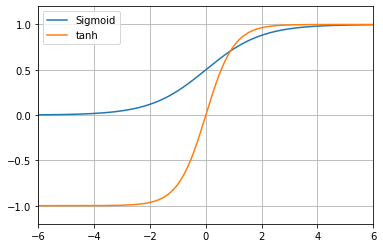

In [18]:
#@title tanh関数
# This code will be hidden when the notebook is loaded.

import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
  return 1.0 / (1.0 + np.exp(-x))

def tanh(x):
  return np.tanh(x)

x = np.arange(-6.0, 6.0, 0.001)
plt.plot(x, sigmoid(x), label = "Sigmoid")
plt.plot(x, tanh(x), label = "tanh")
plt.xlim(-6, 6)
plt.ylim(-1.2, 1.2)
plt.grid()
plt.legend()
plt.show()

- PyTorchでは、以下の活性化関数が用意されている
  - ELU
  - Hardshrink
  - Hardtanh
  - LeakyReLU
  - LogSigmoid
  - MultiheadAttention
  - PReLU
  - ReLU（有名）
  - ReLU6
  - RReLU
  - SELU
  - CELU
  - GELU
  - Sigmoid（シグモイド）
  - Softplus（ソフトプラス）
  - Softshrink
  - Softsign（ソフトサイン）
  - Tanh（本稿で使用）
  - Tanhshrink
  - Threshold
  - Softmin
  - Softmax
  - Softmax2d
  - LogSoftmax
  - AdaptiveLogSoftmaxWithLoss

### リスト1-2　パラメーター（重みとバイアス）の初期値設定

- $w_1=0.6$、$w_2=-0.2$、$b=0.8$と仮定して、ニューロンのモデルを定義
  - ※これらの値は通常は学習により決定されるが、今回は未学習なので仮の固定数値としている
  - 重さ（$w_1$と$w_2$）は2次元配列でまとめて表記する： `weight_array`
    - 通常は、ニューロンは複数あるので、2次元配列で表記する
    - 複数の重みが「行」を構成し、複数のニューロンが「列」を構成する
    - 今回は、重みが**2つ**で、ニューロンが**1つ**なので、**2行1列**で記述する
    -  `[[ 0.6],`<br>&nbsp;&nbsp;`[-0.2]]`
  - バイアス（$b$）は1次元配列でまとめて表記する： `bias_array`
    - `[0.8]`

In [19]:
# パラメーター（ニューロンへの入力で必要となるもの）の定義
weight_array = nn.Parameter(
    torch.tensor([[ 0.6,
                   -0.2]]))  # 重み
bias_array = nn.Parameter(
    torch.tensor([  0.8 ]))  # バイアス

# 重みとバイアスの初期値設定
model.layer1.weight = weight_array
model.layer1.bias = bias_array

# torch.nn.Module全体の状態を辞書形式で取得
params = model.state_dict()
#params = list(model.parameters()) # このように取得することも可能
params
# 出力例：
# OrderedDict([('layer1.weight', tensor([[ 0.6000, -0.2000]])),
#              ('layer1.bias', tensor([0.8000]))])

OrderedDict([('layer1.weight', tensor([[ 0.6000, -0.2000]])),
             ('layer1.bias', tensor([0.8000]))])

このコードのポイント：
- モデルのパラメーターは`torch.nn.Parameter`オブジェクトとして定義する
  - `torch.nn.Parameter`クラスのコンストラクター（厳密には`__init__`関数）には`torch.Tensor`オブジェクト（以下、テンソル）を指定する
  - `torch.Tensor`のコンストラクターにはPythonの多次元リストを指定できる
  - NumPyの多次元配列からのテンソルの作成や、テンソルの使い方については第2回（＝後述）
- 重みやバイアスの初期値設定：
  - `＜モデル名＞.＜レイヤー名＞.weight`プロパティに重みが指定できる
  - `＜モデル名＞.＜レイヤー名＞.baias`プロパティにバイアスが指定できる
  - 通常は「**0**」や「一様分布の**ランダムな値**」などを指定する（第3回＝後述）
- 重みやバイアスといったパラメーターなどの`torch.nn.Module`全体の状態は、`＜モデル名＞.state_dict()`メソッドで取得できる
  - ちなみにパラメーターを最適化で使う際は、`＜モデル名＞.parameters()`メソッドで取得する（第3回＝後述）

## ■（2）フォワードプロパゲーション（順伝播）

### リスト2-1　フォワードプロパゲーションの実行と結果確認
- ニューロンに、座標$(X_1, X_2)$データを入力する
  - 通常のデータは表形式（＝2次元配列）だが、今回は$(1.0, 2.0)$という1つのデータ
    - 1つのデータでも2次元配列（具体的には**1行2列**）で表現する必要がある

In [20]:
X_data = torch.tensor([[1.0, 2.0]])  # 入力する座標データ（1.0、2.0）
print(X_data)
# tensor([[1., 2.]]) ……などと表示される

y_pred = model(X_data)  # このモデルに、データを入力して、出力を得る（＝予測：predict）
print(y_pred)
# tensor([[0.7616]], grad_fn=<TanhBackward>) ……などと表示される

tensor([[1., 2.]])
tensor([[0.7616]], grad_fn=<TanhBackward>)


このコードのポイント：
- フォワードプロパゲーション（順伝播）で、データ（`X_data`）を入力し、モデル（`model`）が推論した結果（`y_pred`）を出力している
- その結果の数値は、手動で計算した値（`0.7616`）と同じになるのが確認できるはず
- `grad_fn`属性（この例では「TanhBackward」）には、勾配（偏微分）などを計算するための関数が自動作成されている。バックプロパゲーション（逆伝播）による学習の際に利用される

### リスト2-2　動的な計算グラフの可視化

「[torchviz · PyPI](https://pypi.org/project/torchviz/)」をインストールして、動的な計算グラフ（dynamic computation graph）を可視化する。


In [21]:
!pip install torchviz          # 初回の「torchviz」パッケージインストール時にのみ必要

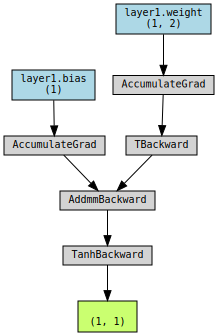

In [22]:
from torchviz import make_dot  # 「torchviz」モジュールから「make_dot」関数をインポート
make_dot(y_pred, params=dict(model.named_parameters()))
# 引数「params」には、全パラメーターの「名前: テンソル」の辞書を指定する。
# 「dict(model.named_parameters())」はその辞書を取得している

この図のポイント：
- 青色のボックス： 勾配を計算する必要がある、重みやバイアスなどのパラメーター。この例では`(1, 2)`が重みで、`(1)`がバイアス
- 灰色のボックス： 勾配（偏微分）などを計算するための関数。「テンソル」データの`grad_fn`属性（この例では「TBackward」や「AddmmBackward」）に自動作成されている。バックプロパゲーション（逆伝播）による学習の際に利用される
- 緑色のボックス： グラフ計算の開始点。`backward()`メソッドを呼び出すと、ここから逆順に計算していく。内容は灰色のボックスと同じ

## ■（3）バックプロパゲーション（逆伝播）と自動微分（Autograd）

### リスト3-1　簡単な式で自動微分してみる

`backward()`メソッドでバックプロパゲーション（誤差逆伝播）をさせる。ニューラルネットワークの誤差逆伝播では、「微分係数（derivative）の計算」という面倒くさい処理が待っている。ディープラーニングのライブラリは、この処理を自動化してくれるので大変便利である。この機能を「自動微分（AD： Automatic differentiation）」や「Autograd」（gradients computed automatically： 自動計算された勾配）などと呼ぶ。

ちなみに詳細を知る必要はあまりないが、`torch.autograd`モジュールは厳密には「リバースモードの自動微分」機能を提供しており、vector-Jacobian product（VJP：ベクトル-ヤコビアン積）と呼ばれる計算を行うエンジンである（参考「[Autograd: Automatic Differentiation — PyTorch Tutorials 1.4.0 documentation](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)」、論文「[Automatic differentiation in PyTorch | OpenReview](https://openreview.net/forum?id=BJJsrmfCZ)」）。

PyTorchの自動微分（Autograd）機能を、非常にシンプルな例で示しておく。

- 計算式： $y=x^2$
- 導関数： $\frac{dy}{dx}=2x$ （ $y$ を $x$ で微分する）
- 例えば $x$ が__1.0__の地点の勾配（＝接線の傾き）は__2.0__となる

In [23]:
x = torch.tensor(1.0, requires_grad=True)  # 今回は入力に勾配（gradient）を必要とする
# 「requires_grad」が「True」（デフォルト：False）の場合、
# torch.autogradが入力テンソルに関するパラメーター操作（勾配）を記録するようになる

#x.requires_grad_(True)  # 「requires_grad_()」メソッドで後から変更することも可能

y = x ** 2     # 「yイコールxの二乗」という計算式の計算グラフを構築
print(y)       # tensor(1., grad_fn=<PowBackward0>) ……などと表示される

y.backward()   # 逆伝播の処理として、上記式から微分係数（＝勾配）を計算（自動微分：Autograd）

g = x.grad     # 与えられた入力（x）によって計算された勾配の値（grad）を取得
print(g)       # tensor(2.)  ……などと表示される
# 計算式の微分係数（＝勾配）を計算するための導関数は「dy/dx=2x」なので、
#「x=1.0」地点の勾配（＝接線の傾き）は「2.0」となり、出力結果は正しい。
# 例えば「x=0.0」地点の勾配は「0.0」、「x=10.0」地点の勾配は「20.0」である

tensor(1., grad_fn=<PowBackward0>)
tensor(2.)


このコードのポイント：
- PyTorchが「自動微分」機能を持つライブラリであることが確認できた
- 出力されたテンソル（`y`）の`backward()`メソッドでバックプロパゲーション（逆伝播）を実行できる。なお、ニューラルネットワークの場合は、損失を表すテンソルの`backward()`メソッドを呼び出すことになる
  - 出力されたテンソルの計算式（`y`）を入力したテンソル(`x`)で微分計算している
- 計算された微分係数（＝勾配：gradient）は、入力したテンソルの`grad`プロパティで取得できる

### リスト3-2　ニューラルネットワークにおける各パラメーターの勾配

In [24]:
# 勾配計算の前に、各パラメーター（重みやバイアス）の勾配の値（grad）をリセットしておく
model.layer1.weight.grad = None      # 重み
model.layer1.bias.grad = None        # バイアス
#model.zero_grad()                   # これを呼び出しても上記と同じくリセットされる

X_data = torch.tensor([[1.0, 2.0]])  # 入力データ（※再掲）
y_pred = model(X_data)               # 出力結果（※再掲）
y_true = torch.tensor([[1.0]])       # 正解ラベル

criterion = nn.MSELoss()             # 誤差からの損失を測る「基準」＝損失関数
loss = criterion(y_pred, y_true)     # 誤差（出力結果と正解ラベルの差）から損失を取得
loss.backward()   # 逆伝播の処理として、勾配を計算（自動微分：Autograd）

# 勾配の値（grad）は、各パラメーター（重みやバイアス）から取得できる
print(model.layer1.weight.grad) # tensor([[-0.2002, -0.4005]])  ……などと表示される
print(model.layer1.bias.grad)   # tensor([-0.2002])  ……などと表示される
# ※パラメーターは「list(model.parameters())」で取得することも可能

tensor([[-0.2002, -0.4005]])
tensor([-0.2002])


このコードのポイント：
- `criterion`に損失関数を代入するのが定石
- `backward`メソッドによるバックプロパゲーション
- この例では単純にするために1回しか処理してないが、本来はミニバッチのイテレーションや全体のエポックの回数繰り返し処理必要がある（第3回＝後述）
- モデルにおける各パラメーター（`weight`や`bias`）の`grad`プロパティから、勾配の値は取得できる